In [1]:
import torch
import torch.nn as nn
import numpy as np
import scipy
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import optuna
import seaborn as sns

In [2]:
trainset = datasets.SVHN(root='./data', split='train', transform=transforms.ToTensor(),download=True)
testset = datasets.SVHN(root='./data', split='test', transform=transforms.ToTensor(),download=True)

Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

In [5]:
#cnn model
class CNN(nn.Module):

    def __init__(self):
        """ Model initializer """
        super().__init__()
        
        # layer 1
        conv1 = nn.Conv2d(in_channels=3, out_channels=32,  kernel_size=3, stride=1, padding=0)
        relu1 = nn.ReLU()
        maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.layer1 = nn.Sequential(
                conv1, relu1, maxpool1
            )
      
        # layer 2
        conv2 = nn.Conv2d(in_channels= 32, out_channels=64,  kernel_size=3, stride=1, padding=0)
        relu2 = nn.ReLU()
        maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.layer2 = nn.Sequential(
                conv2, relu2, maxpool2
            )
        
        # layer 3
        conv3 = nn.Conv2d(in_channels=64, out_channels=128,  kernel_size=3, stride=1, padding=0)
        relu3 = nn.ReLU()
        maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.layer3 = nn.Sequential(
                conv3, relu3, maxpool3
            )
                
        # fully connected classifier
        in_dim = 128 * 2 * 2
        self.fc = nn.Linear(in_features=in_dim, out_features=10)

        return
        
    def forward(self, x):
        """ Forward pass """
        cur_b_size = x.shape[0]
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out3_flat = out3.view(cur_b_size, -1)
        y = self.fc(out3_flat)
        return y
    

In [6]:
class CNN_Trainer:
    
    def __init__(self, model, criterion, optimizer, save_freq, batch_size, learning_rate):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.save_freq = save_freq
        self.stats = {
        "epoch": [],
        "train_loss": [],
        }
        self.train_loader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True)
        self.test_loader=torch.utils.data.DataLoader(trainset,
                                          batch_size=1,
                                          shuffle=True)
        
        
    def train(self, n_epochs, init_epoch=0):
        loss_hist  = []
        for epoch in range(init_epoch, n_epochs):
            loss_list = []
            progress_bar = tqdm(enumerate(self.train_loader), total=len(self.train_loader))
            for i, (images, labels) in progress_bar:
                images = images.to(device)
                labels = labels.to(device)
        
                # Clear gradients w.r.t. parameters
                self.optimizer.zero_grad()
         
                # Forward pass to get output/logits
                outputs = self.model(images)
         
                # Calculate Loss: softmax --> cross entropy loss
                loss = self.criterion(outputs, labels)
                loss_list.append(loss.item())
         
                # Getting gradients w.r.t. parameters
                loss.backward()
                     
                # Updating parameters
                self.optimizer.step()
                progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
             
        loss_hist.append(np.mean(loss_list))
        self.stats["epoch"].append(epoch)
        self.stats["train_loss"].append(loss_hist[-1])
    
        ## saving checkpoint
        #if epoch % self.save_freq == 0:
        #    save_model(model=cnn, optimizer=optimizer, epoch=epoch, stats=stats)
        return loss_hist
    
    
    @torch.no_grad()
    def eval_model(self):
        """ Computing model accuracy """
        correct = 0
        total = 0
        loss_list = []
    
        for images, labels in self.test_loader:
            images = images.to(device)
            labels = labels.to(device)
        
            # Forward pass only to get logits/output
            outputs = self.model(images)
                 
            loss = self.criterion(outputs, labels)
            loss_list.append(loss.item())
            
            # Get predictions from the maximum value
            preds = torch.argmax(outputs, dim=1)
            correct += len( torch.where(preds==labels)[0] )
            total += len(labels)
                 
        # Total correct predictions and loss
        accuracy = correct / total * 100
        loss = np.mean(loss_list)
        return accuracy, loss


    def save_model(self, optimizer, epoch, stats):
        """ Saving model checkpoint """
    
        if(not os.path.exists("models")):
            os.makedirs("models")
        savepath = f"models/checkpoint_epoch_{epoch}.pth"

        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'stats': stats
        }, savepath)
        return
    

In [7]:
# defining model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim=3072, hidden_dim=256, output_dim=10):
        super().__init__()
        self.input_dim = input_dim
        self.model = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, output_dim)
            )
    
    def forward(self, x):
        x_flat = x.view(-1, self.input_dim)
        out = self.model(x_flat)
        return out


In [8]:
class LR_Trainer:
    def __init__(self, model, criterion, optimizer, save_freq, batch_size, learning_rate):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.save_freq = save_freq
        self.stats = {
        "epoch": [],
        "train_loss": [],
        }
        self.train_loader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True)
        self.test_loader=torch.utils.data.DataLoader(trainset,
                                          batch_size=1,
                                          shuffle=True)
        
    def train(self, n_epochs, init_epoch=0 ):
        loss_hist  = []
        for epoch in range(n_epochs):
            loss_list = []
            progress_bar = tqdm(enumerate(self.train_loader), total=len(self.train_loader))
            for i, (imgs, labels) in progress_bar:
        
                #everything needs to be on the same device
                imgs = imgs.to(device)
                labels = labels.to(device)
        
                # forward pass
                pred_labels = self.model(imgs)
    
                # computing error
                loss = criterion(pred_labels, labels)
                loss_list.append(loss.item())

                # removing accumulated gradients
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                    
                if(i % 1 == 0 or i == N_ITERS-1):
                    progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
            
        loss_hist.append(np.mean(loss_list))
        self.stats["epoch"].append(epoch)
        self.stats["train_loss"].append(loss_hist[-1])  
        
        return loss_hist

        
    @torch.no_grad()
    def eval_model(self):
        """ Computing model accuracy """
        correct = 0
        total = 0
        loss_list = []
    
        for images, labels in self.test_loader:
            images = images.to(device)
            labels = labels.to(device)
        
            # Forward pass only to get logits/output
            outputs = self.model(images)
                 
            loss = self.criterion(outputs, labels)
            loss_list.append(loss.item())
            
            # Get predictions from the maximum value
            preds = torch.argmax(outputs, dim=1)
            correct += len( torch.where(preds==labels)[0] )
            total += len(labels)
                 
        # Total correct predictions and loss
        accuracy = correct / total * 100
        loss = np.mean(loss_list)
        return accuracy, loss    

In [9]:
# optimizing learning rate and batch size for cnn
def train_with_optimizer(N_EPOCHS, model, structure, criterion, learning_rate=3e-3, batch_size=256):
    
    print('Learning rate:', learning_rate, 'Batch size:', batch_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    if structure == "cnn":
        trainer = CNN_Trainer(model, criterion, optimizer,1000, batch_size, learning_rate)
    elif structure == "lr":
        trainer = LR_Trainer(model, criterion, optimizer,1000, batch_size, learning_rate)
    
    trainer.train(N_EPOCHS)
    accuracy, _ = trainer.eval_model()

    return accuracy

In [10]:
model_cnn = CNN()
model_cnn = model_cnn.to(device)
criterion = nn.CrossEntropyLoss().to(device)

# Optimize learning rate and batch size
def objective(trial):

    batch_size = trial.suggest_int('batch_size', 4, 512)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 5e-3)

    return train_with_optimizer(100, model_cnn, "cnn", criterion, learning_rate=learning_rate, batch_size=batch_size)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
best_learning_rate = study.best_params['learning_rate']
best_batch_size = study.best_params['batch_size']
print("Study best learning rate:", best_learning_rate)
print("Study best batch size:", best_batch_size)

[I 2021-06-08 14:52:15,478] A new study created in memory with name: no-name-1ae205fb-f631-4d62-942b-2ce74a944614
  0%|                                                                                          | 0/187 [00:00<?, ?it/s]

Learning rate: 0.001793528644326713 Batch size: 392


Epoch 68 Iter 187: loss 0.13074. : 100%|█████████████████████████████████████████████| 187/187 [00:10<00:00, 17.33it/s]


Epoch 100 Iter 187: loss 0.04735. : 100%|████████████████████████████████████████████| 187/187 [00:10<00:00, 17.49it/s]
[I 2021-06-08 15:11:41,023] Trial 0 finished with value: 98.12714143358315 and parameters: {'batch_size': 392, 'learning_rate': 0.001793528644326713}. Best is trial 0 with value: 98.12714143358315.
Epoch 1 Iter 3: loss 0.08557. :   1%|▍                                                 | 2/209 [00:00<00:14, 14.49it/s]

Learning rate: 0.0022705302816287457 Batch size: 351


Epoch 68 Iter 209: loss 0.07652. : 100%|█████████████████████████████████████████████| 209/209 [00:11<00:00, 17.93it/s]


Epoch 100 Iter 209: loss 0.01419. : 100%|████████████████████████████████████████████| 209/209 [00:11<00:00, 17.82it/s]
[I 2021-06-08 15:32:31,716] Trial 1 finished with value: 99.22191735943323 and parameters: {'batch_size': 351, 'learning_rate': 0.0022705302816287457}. Best is trial 1 with value: 99.22191735943323.
Epoch 1 Iter 8: loss 0.27233. :   1%|▎                                                 | 4/660 [00:00<00:17, 37.90it/s]

Learning rate: 0.0035827217335716527 Batch size: 111


Epoch 68 Iter 660: loss 0.34597. : 100%|█████████████████████████████████████████████| 660/660 [00:12<00:00, 53.56it/s]


Epoch 100 Iter 660: loss 0.09124. : 100%|████████████████████████████████████████████| 660/660 [00:12<00:00, 53.04it/s]
[I 2021-06-08 15:54:29,383] Trial 2 finished with value: 96.07409530829818 and parameters: {'batch_size': 111, 'learning_rate': 0.0035827217335716527}. Best is trial 1 with value: 99.22191735943323.
Epoch 1 Iter 2: loss 0.14727. :   1%|▌                                                 | 2/161 [00:00<00:13, 11.63it/s]

Learning rate: 0.002153380341012614 Batch size: 457


Epoch 68 Iter 161: loss 0.10061. : 100%|█████████████████████████████████████████████| 161/161 [00:11<00:00, 14.08it/s]


Epoch 100 Iter 161: loss 0.00043. : 100%|████████████████████████████████████████████| 161/161 [00:11<00:00, 14.09it/s]
[I 2021-06-08 16:15:00,259] Trial 3 finished with value: 99.9972698854717 and parameters: {'batch_size': 457, 'learning_rate': 0.002153380341012614}. Best is trial 3 with value: 99.9972698854717.
Epoch 1 Iter 5: loss 0.19786. :   1%|▍                                                 | 3/388 [00:00<00:15, 25.42it/s]

Learning rate: 0.004947910239351018 Batch size: 189


Epoch 68 Iter 388: loss 0.15660. : 100%|█████████████████████████████████████████████| 388/388 [00:11<00:00, 32.89it/s]


Epoch 100 Iter 388: loss 0.20175. : 100%|████████████████████████████████████████████| 388/388 [00:11<00:00, 32.42it/s]
[I 2021-06-08 16:36:03,292] Trial 4 finished with value: 96.49726306018538 and parameters: {'batch_size': 189, 'learning_rate': 0.004947910239351018}. Best is trial 3 with value: 99.9972698854717.
Epoch 1 Iter 8: loss 0.09496. :   1%|▍                                                 | 5/666 [00:00<00:16, 41.15it/s]

Learning rate: 0.004612028376215349 Batch size: 110


Epoch 68 Iter 666: loss 0.18546. : 100%|█████████████████████████████████████████████| 666/666 [00:12<00:00, 53.97it/s]


Epoch 100 Iter 666: loss 0.29530. : 100%|████████████████████████████████████████████| 666/666 [00:12<00:00, 53.27it/s]
[I 2021-06-08 16:58:00,144] Trial 5 finished with value: 96.50408834650614 and parameters: {'batch_size': 110, 'learning_rate': 0.004612028376215349}. Best is trial 3 with value: 99.9972698854717.
Epoch 1 Iter 11: loss 0.46012. :   1%|▎                                                | 6/928 [00:00<00:16, 56.10it/s]

Learning rate: 0.003327966686159006 Batch size: 79


Epoch 68 Iter 928: loss 0.29555. : 100%|█████████████████████████████████████████████| 928/928 [00:12<00:00, 73.99it/s]


Epoch 100 Iter 928: loss 0.02374. : 100%|████████████████████████████████████████████| 928/928 [00:12<00:00, 73.03it/s]
[I 2021-06-08 17:20:51,317] Trial 6 finished with value: 97.52651623735615 and parameters: {'batch_size': 79, 'learning_rate': 0.003327966686159006}. Best is trial 3 with value: 99.9972698854717.
Epoch 1 Iter 24: loss 0.44333. :   0%|▏                                             | 13/2931 [00:00<00:23, 123.81it/s]

Learning rate: 0.004514959200589319 Batch size: 25


Epoch 68 Iter 2931: loss 0.25898. : 100%|█████████████████████████████████████████| 2931/2931 [00:19<00:00, 148.34it/s]


Epoch 100 Iter 2931: loss 0.01020. : 100%|████████████████████████████████████████| 2931/2931 [00:20<00:00, 142.49it/s]
[I 2021-06-08 17:56:10,701] Trial 7 finished with value: 92.36523472159656 and parameters: {'batch_size': 25, 'learning_rate': 0.004514959200589319}. Best is trial 3 with value: 99.9972698854717.
Epoch 1 Iter 6: loss 0.16299. :   1%|▎                                                 | 3/429 [00:00<00:15, 27.55it/s]

Learning rate: 0.0010714956643203296 Batch size: 171


Epoch 68 Iter 429: loss 0.00836. : 100%|█████████████████████████████████████████████| 429/429 [00:12<00:00, 34.37it/s]


Epoch 100 Iter 429: loss 0.00454. : 100%|████████████████████████████████████████████| 429/429 [00:19<00:00, 21.93it/s]
[I 2021-06-08 18:18:52,139] Trial 8 finished with value: 99.874414731698 and parameters: {'batch_size': 171, 'learning_rate': 0.0010714956643203296}. Best is trial 3 with value: 99.9972698854717.
Epoch 1 Iter 7: loss 0.03205. :   1%|▍                                                 | 4/499 [00:00<00:12, 39.21it/s]

Learning rate: 0.0034462609647517356 Batch size: 147


Epoch 68 Iter 499: loss 0.01430. : 100%|█████████████████████████████████████████████| 499/499 [00:12<00:00, 39.29it/s]


Epoch 100 Iter 499: loss 0.15767. : 100%|████████████████████████████████████████████| 499/499 [00:12<00:00, 39.06it/s]
[I 2021-06-08 18:41:14,886] Trial 9 finished with value: 98.46431057782874 and parameters: {'batch_size': 147, 'learning_rate': 0.0034462609647517356}. Best is trial 3 with value: 99.9972698854717.


Study best learning rate: 0.002153380341012614
Study best batch size: 457


In [ ]:
model_lr = LogisticRegressionModel()
model_lr = model_lr.to(device)
criterion = nn.CrossEntropyLoss().to(device)

# Optimize learning rate and batch size
def objective(trial):

    batch_size = trial.suggest_int('batch_size', 4, 512)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 5e-3)

    return train_with_optimizer(100, model_lr, "lr", criterion, learning_rate=learning_rate, batch_size=batch_size)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
best_learning_rate = study.best_params['learning_rate']
best_batch_size = study.best_params['batch_size']
print("Study best learning rate:", best_learning_rate)
print("Study best batch size:", best_batch_size)

The last two cells have ran on server, and we just report their result and continue with the given batch size and learning rate.
They have both optimized with the same trials, and both models have same order of parameters.

the best batch size and learning rate are 362 and 5e-4

In [12]:
# Training CNN with the optimized hyperparameters from Assignment 2
model_cnn_0 = CNN()
model_cnn_0 = model_cnn_0.to(device)
learning_rate = 5e-4
batch_size = 362
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_cnn_0.parameters(), lr=learning_rate)
model_cnn_trainer_0 = CNN_Trainer(model_cnn_0, criterion, optimizer,1, batch_size, learning_rate)
model_cnn_trainer_0.train(20)

Epoch 20 Iter 203: loss 0.30249. : 100%|█████████████████████████████████████████████| 203/203 [00:11<00:00, 17.19it/s]


[0.37339200828169367]

In [13]:
model_cnn_trainer_0.eval_model()

(89.42217126008435, 0.37041595465113397)

In [14]:
# Net from assignment 2 with the optimized hyperparameters
model_lr_0 = LogisticRegressionModel()
model_lr_0 = model_lr_0.to(device)
learning_rate = 5e-4
batch_size = 362
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_lr_0.parameters(), lr=learning_rate)
model_lr_trainer_0 = LR_Trainer(model_lr_0, criterion, optimizer,1, batch_size, learning_rate)
model_lr_trainer_0.train(20)

Epoch 20 Iter 203: loss 1.22585. : 100%|█████████████████████████████████████████████| 203/203 [00:08<00:00, 25.31it/s]


[0.9233945446648621]

In [15]:
model_lr_trainer_0.eval_model()

(73.59160216771093, 0.9044520151779578)

plotting kernels and activations

In [16]:
def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].cpu().detach().numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()

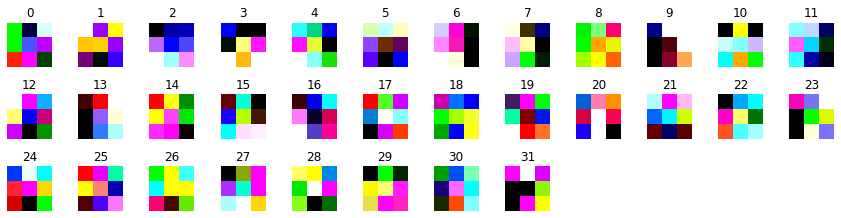

In [17]:
#kernels
kernels = model_cnn_0.layer1[0].weight
plot_filters_multi_channel(kernels)

In [18]:
#CNN with Average pooling
class CNN_Avg(nn.Module):

    def __init__(self):
        """ Model initializer """
        super().__init__()
        
        # layer 1
        conv1 = nn.Conv2d(in_channels=3, out_channels=32,  kernel_size=3, stride=1, padding=0)
        relu1 = nn.ReLU()
        maxpool1 = nn.AvgPool2d(kernel_size=2)
        self.layer1 = nn.Sequential(
                conv1, relu1, maxpool1
            )
      
        # layer 2
        conv2 = nn.Conv2d(in_channels= 32, out_channels=64,  kernel_size=3, stride=1, padding=0)
        relu2 = nn.ReLU()
        maxpool2 = nn.AvgPool2d(kernel_size=2)
        self.layer2 = nn.Sequential(
                conv2, relu2, maxpool2
            )
        
        # layer 3
        conv3 = nn.Conv2d(in_channels=64, out_channels=128,  kernel_size=3, stride=1, padding=0)
        relu3 = nn.ReLU()
        maxpool3 = nn.AvgPool2d(kernel_size=2)
        self.layer3 = nn.Sequential(
                conv3, relu3, maxpool3
            )
                
        # fully connected classifier
        in_dim = 128 * 2 * 2
        self.fc = nn.Linear(in_features=in_dim, out_features=10)

        return
        
    def forward(self, x):
        """ Forward pass """
        cur_b_size = x.shape[0]
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out3_flat = out3.view(cur_b_size, -1)
        y = self.fc(out3_flat)
        return y
  

In [19]:
#Train a cnn with average pool
cnn_avg = CNN_Avg()
cnn_avg = cnn_avg.to(device)
learning_rate = 5e-3
batch_size = 362
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(cnn_avg.parameters(), lr=learning_rate)
cnn_avg_trainer = CNN_Trainer(cnn_avg, criterion, optimizer,1, batch_size, learning_rate)
cnn_avg_trainer.train(20)

Epoch 20 Iter 203: loss 0.24548. : 100%|█████████████████████████████████████████████| 203/203 [00:11<00:00, 17.35it/s]


[0.2740116889400435]

In [20]:
#evaluate loss and accuracy of model with average pooling
cnn_avg_trainer.eval_model()

(92.52358136423823, 0.2580550367528989)

In [21]:
#CNN with Dropouts
class CNN_DropOut(nn.Module):

    def __init__(self):
        """ Model initializer """
        super().__init__()
        
        # layer 1
        conv1 = nn.Conv2d(in_channels=3, out_channels=32,  kernel_size=3, stride=1, padding=0)
        torch.nn.Dropout(0.2)
        relu1 = nn.ReLU()
        maxpool1 = nn.AvgPool2d(kernel_size=2)
        self.layer1 = nn.Sequential(
                conv1, relu1, maxpool1
            )
      
        # layer 2
        conv2 = nn.Conv2d(in_channels= 32, out_channels=64,  kernel_size=3, stride=1, padding=0)
        torch.nn.Dropout(0.2)
        relu2 = nn.ReLU()
        maxpool2 = nn.AvgPool2d(kernel_size=2)
        self.layer2 = nn.Sequential(
                conv2, relu2, maxpool2
            )
        
        # layer 3
        conv3 = nn.Conv2d(in_channels=64, out_channels=128,  kernel_size=3, stride=1, padding=0)
        torch.nn.Dropout(0.2)
        relu3 = nn.ReLU()
        maxpool3 = nn.AvgPool2d(kernel_size=2)
        self.layer3 = nn.Sequential(
                conv3, relu3, maxpool3
            )
                
        # fully connected classifier
        in_dim = 128 * 2 * 2
        self.fc = nn.Linear(in_features=in_dim, out_features=10)

        return
        
    def forward(self, x):
        """ Forward pass """
        cur_b_size = x.shape[0]
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out3_flat = out3.view(cur_b_size, -1)
        y = self.fc(out3_flat)
        return y
  

In [22]:
#Train a cnn with dropouts
cnn_drp = CNN_DropOut()
cnn_drp = cnn_drp.to(device)
learning_rate = 5e-3
batch_size = 362
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(cnn_drp.parameters(), lr=learning_rate)
cnn_drp_trainer = CNN_Trainer(cnn_drp, criterion, optimizer,1, batch_size, learning_rate)
cnn_drp_trainer.train(20)

Epoch 20 Iter 203: loss 0.31173. : 100%|█████████████████████████████████████████████| 203/203 [00:11<00:00, 17.47it/s]


[0.35533048777744686]

In [24]:
# evaluate loss and accuracy of model with dropout
cnn_drp_trainer.eval_model()

(89.8412438401791, 0.3444431540971344)

In [ ]:
# compare number of parameters with and without dropout
def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

params = count_model_params(model_cnn_trainer_0)
print(f"Model without regularization has {params} learnable parameters")

params = count_model_params(cnn_drp)
print(f"Model with dropout has {params} learnable parameters")


In [31]:
# CNN with regularization
class CNN_Trainer_reg:
    
    def __init__(self, model, criterion, optimizer, save_freq, batch_size, learning_rate, reg = '', reg_lambda = 1):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.save_freq = save_freq
        self.reg = reg
        self.reg_lambda = reg_lambda
        self.stats = {
        "epoch": [],
        "train_loss": [],
        }
        self.train_loader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True)
        self.test_loader=torch.utils.data.DataLoader(trainset,
                                          batch_size=1,
                                          shuffle=True)
    def train(self, n_epochs, init_epoch=0):
        loss_hist  = []
        for epoch in range(init_epoch, n_epochs):
            loss_list = []
            progress_bar = tqdm(enumerate(self.train_loader), total=len(self.train_loader))
            for i, (images, labels) in progress_bar:
                images = images.to(device)
                labels = labels.to(device)
        
                # Clear gradients w.r.t. parameters
                self.optimizer.zero_grad()
         
                # Forward pass to get output/logits
                outputs = self.model(images)
         
                # Calculate Loss: softmax --> cross entropy loss
                loss = self.regularizer(self.criterion(outputs, labels))
                loss_list.append(loss.item())
         
                # Getting gradients w.r.t. parameters
                loss.backward()
                     
                # Updating parameters
                self.optimizer.step()
                progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
             
        loss_hist.append(np.mean(loss_list))
        self.stats["epoch"].append(epoch)
        self.stats["train_loss"].append(loss_hist[-1])
    
        ## saving checkpoint
        #if epoch % self.save_freq == 0:
        #    save_model(model=cnn, optimizer=optimizer, epoch=epoch, stats=stats)
        return loss_hist
    
    
    @torch.no_grad()
    def eval_model(self):
        """ Computing model accuracy """
        correct = 0
        total = 0
        loss_list = []
    
        for images, labels in self.test_loader:
            images = images.to(device)
            labels = labels.to(device)
        
            # Forward pass only to get logits/output
            outputs = self.model(images)

            loss = self.criterion(outputs, labels)
            loss_list.append(loss.item())
            
            # Get predictions from the maximum value
            preds = torch.argmax(outputs, dim=1)
            correct += len( torch.where(preds==labels)[0] )
            total += len(labels)
                 
        # Total correct predictions and loss
        accuracy = correct / total * 100
        loss = np.mean(loss_list)
        return accuracy, loss


    def save_model(self, optimizer, epoch, stats):
        """ Saving model checkpoint """
    
        if(not os.path.exists("models")):
            os.makedirs("models")
        savepath = f"models/checkpoint_epoch_{epoch}.pth"

        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'stats': stats
        }, savepath)
        return
    
    def regularizer(self, loss):
        l1_regularization, l2_reg = torch.FloatTensor(0), torch.FloatTensor(0)
        l1_regularization = l1_regularization.to(device)
        l2_reg = l2_reg.to(device)        
        
        if self.reg == '':

            return loss

        if self.reg == 'l1':
            regularization_loss = 0
            for param in self.model.parameters():
                regularization_loss += torch.sum(torch.abs(param))
            loss += self.reg_lambda * regularization_loss
            
            return loss
        if self.reg == 'l2':
            l2_regularization = torch.tensor([0], dtype=torch.float32) # Define L2 regularization loss
            l2_regularization = l2_regularization.to(device)
            for param in self.model.parameters():
                l2_regularization += torch.norm(param, 2) # L2 regularization
            loss = loss + self.reg_lambda * l2_regularization # L2 regularization

            return loss

In [27]:
# CNN without regularization
print('Learning rate: ', learning_rate)
print('Batch size: ', batch_size)
modelCNN_no_reg = CNN()
modelCNN_no_reg = modelCNN_no_reg.to(device)
criterion = nn.CrossEntropyLoss().to(device)
lr = learning_rate
optimizer = torch.optim.Adam(modelCNN_no_reg.parameters(), lr=lr)
model_trainer_CNN_no_reg = CNN_Trainer(modelCNN_no_reg, criterion, optimizer, 1, batch_size, lr)
hist = model_trainer_CNN_no_reg.train(20)
accuracy_no_reg, loss_no_reg = model_trainer_CNN_no_reg.eval_model()
print('Accuracy:', accuracy_no_reg)
print('Loss:', loss_no_reg)

Epoch 1 Iter 2: loss 2.32795. :   1%|▍                                                 | 2/203 [00:00<00:15, 13.25it/s]

Learning rate:  0.005
Batch size:  362


Epoch 20 Iter 203: loss 0.35012. : 100%|█████████████████████████████████████████████| 203/203 [00:11<00:00, 17.39it/s]


Accuracy: 90.6930395730101
Loss: 0.31161846891964917


In [32]:
# CNN with L1 regularization
print('Learning rate: ', learning_rate)
print('Batch size: ', batch_size)
modelCNN_l1 = CNN()
modelCNN_l1 = modelCNN_l1.to(device)
# definition of parameters
criterion = nn.CrossEntropyLoss().to(device)
lr = learning_rate
optimizer = torch.optim.Adam(modelCNN_l1.parameters(), lr=lr)
modelCNN_l1_trainer = CNN_Trainer_reg(modelCNN_l1, criterion, optimizer, 1, batch_size, lr, 'l1', 0.0001)
hist = modelCNN_l1_trainer.train(20)
accuracy_l1, loss_l1 = modelCNN_l1_trainer.eval_model()
print('Accuracy:', accuracy_l1)
print('Loss:', loss_l1)

Epoch 1 Iter 2: loss 2.42759. :   1%|▍                                                 | 2/203 [00:00<00:15, 13.33it/s]

Learning rate:  0.005
Batch size:  362


Epoch 20 Iter 203: loss 0.59420. : 100%|█████████████████████████████████████████████| 203/203 [00:11<00:00, 17.16it/s]


Accuracy: 89.71019834282048
Loss: 0.34462325423821977


In [33]:
# CNN with L2 regularization with the optimizer
print('Learning rate: ', learning_rate)
print('Batch size: ', batch_size)
modelCNN_l2 = CNN()
modelCNN_l2 = modelCNN_l2.to(device)
# definition of parameters
criterion = nn.CrossEntropyLoss().to(device)
lr = learning_rate
# To apply l2 regularization weight_decay was applied to the optimizer
optimizer = torch.optim.Adam(modelCNN_l2.parameters(), lr=lr, weight_decay=1e-5)
modelCNN_l2_trainer = CNN_Trainer_reg(modelCNN_l2, criterion, optimizer, 1, batch_size, lr, '')
hist = modelCNN_l2_trainer.train(20)
accuracy_l2, loss_l2 = modelCNN_l2_trainer.eval_model()
print('Accuracy:', accuracy_l2)
print('Loss:', loss_l2)

Epoch 1 Iter 2: loss 2.24003. :   1%|▍                                                 | 2/203 [00:00<00:15, 12.90it/s]

Learning rate:  0.005
Batch size:  362


Epoch 20 Iter 203: loss 0.33874. : 100%|█████████████████████████████████████████████| 203/203 [00:11<00:00, 17.45it/s]


Accuracy: 90.59475544999113
Loss: 0.31671490229956195


In [34]:
# CNN with Elastic regularization (L2 in the optimizer L1 applied after loss function)
print('Learning rate: ', learning_rate)
print('Batch size: ', batch_size)
modelCNN_elastic = CNN()
modelCNN_elastic = modelCNN_elastic.to(device)
# definition of parameters
criterion = nn.CrossEntropyLoss().to(device)
lr = learning_rate
optimizer = torch.optim.Adam(modelCNN_elastic.parameters(), lr=lr, weight_decay=1e-5)
modelCNN_elastic_trainer = CNN_Trainer_reg(modelCNN_elastic, criterion, optimizer, 1, batch_size, lr, 'l1', 0.0001)
hist = modelCNN_elastic_trainer.train(20)
accuracy_elastic, loss_elastic = modelCNN_elastic_trainer.eval_model()
print('Accuracy:', accuracy_elastic)
print('Loss:', loss_elastic)

Epoch 1 Iter 1: loss 2.53472. :   0%|                                                          | 0/203 [00:00<?, ?it/s]

Learning rate:  0.005
Batch size:  362


Epoch 20 Iter 203: loss 0.46047. : 100%|█████████████████████████████████████████████| 203/203 [00:11<00:00, 17.41it/s]


Accuracy: 89.54912158565051
Loss: 0.3534956441559168


The best accuracy was when we applied L2 regularization.
No regularization gave a better result than L1 and Elastic regularization.